<a href="https://colab.research.google.com/github/robosquiggles/2156_Demos/blob/main/2_156_Fall_24_Demo_6_Multimodal_Predictors_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2.155/6 Multimodal Neural Networks and AutoML**


<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

---

Table of Contents:

Installs and Imports
Setting up data

Part 1.

  A: Neural Net using Parameter Data (DNN)

  B: Neural Net using Image Data (CNN)

  C: Neural Net using Image and Param Data (Hybrid NN)

Part 2.

  A: AutoGluon using Parameter Data (AG Tabular)

  B: Autogluon using Image Data (AG Multimodal)

  C: Autogluon using Parameter and Image Data (AG Multimodal)


## **Notebook Description**
In this notebook, we will implement a neural network to make predictions on multimodal data. We will then train AutoGluon models to compare.

# Installs and Imports

Note: **We have set up the packages and installs to work with GPU. Please make sure you are using a GPU runtime.** If colab bottlenecks you, you can consider signing up for colab +, or using a different google account. Remember that we will reimburse up to $50 of compute for the class if you save receipts (though we can't reimburse tax).

In [1]:
!pip install -q condacolab

import condacolab
condacolab.install()
assert False #Stop Execution to Restart Runtime

✨🍰✨ Everything looks OK!


AssertionError: 


**The cell above is supposed to error out. Navigate to runtime -> restart session. Then click the cell below and click "run cell and below" to run the rest of the notebook:**

**The next line will install autogluon and will take several minutes to run. If you are only running part 1 of the demo [2.155], you can comment this next cell out or start running at the cell below to save time.**

In [1]:
!mamba install -c conda-forge autogluon "pytorch=*=cuda*" torchaudio -y #Only run if doing section 2
from autogluon.tabular import TabularPredictor
from autogluon.multimodal import MultiModalPredictor


Looking for: ['autogluon', 'pytorch=[build=cuda*]', 'torchaudio']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  10%
conda-forge/noarch    ⣾  [+] 0.3s
conda-forge/linux-64  15%
conda-forge/noarch    18%[+] 0.4s
conda-forge/linux-64  32%
conda-forge/noarch    37%[+] 0.5s
conda-forge/linux-64  32%
conda-forge/noarch    46%[+] 0.6s
conda-forge/linux-64  36%
conda-forge/noarch    54%[+] 0.7s
conda-forge/linux-64  40%
conda-forge/noarch    64%[+] 0.8s
conda-forge/linux-64  44%
conda-forge/noarch    64%[+] 0.9s
conda-forge/linux-64  48%
conda-forge/noarch    73%[+] 1.0s
conda-forge/linux-64  52%
conda-forge/noarch    93%conda-forge/noarch                                
[+] 1.1s
conda-forge/linux-64  61%[+] 1.2s
conda-forge/linux-64  77%[+] 1.3s
conda-forge/linux-64  77%[+] 1.4s
conda-forge/linux-64  83%[+] 1.5s
conda-forge/linux-64  87%conda-forge/linux-64                              


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from tqdm.autonotebook import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Preparing Data**

First, lets grab the data from Github. This cell may take a few seconds.

In [3]:
url = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/BIKED_processed.csv'
params = pd.read_csv(url, index_col=0)
url='https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/Classification/Bikestyle.csv'
classes = pd.read_csv(url, index_col=0)

image_dir = 'https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/BIKED_Im/'
image_batches=[]
for i in trange(12): # We split the images into 12 files to bypass github limits.
    filename = f"images_{i}.npy"
    file_url = image_dir + filename
    !wget -q {file_url}
    image_batches.append(np.load(filename))
images = np.vstack(image_batches) # We concatenate here


  0%|          | 0/12 [00:00<?, ?it/s]

Let's dig into the data a bit. First, we visualize the shape our data:

In [4]:
print(f'Shape of parameter data: {params.shape}')
print(f'Shape of image data: {images.shape}')
print(f'Shape of class data: {classes.shape}')

Shape of parameter data: (4512, 2401)
Shape of image data: (4512, 120, 260)
Shape of class data: (4512, 1)


As you can see we 4512 sets of parameter, image, and class label values. Parametric data consists of vectors of size 2402. Image data consists of images with size 120px x 260px. Now we visualize some of the images...

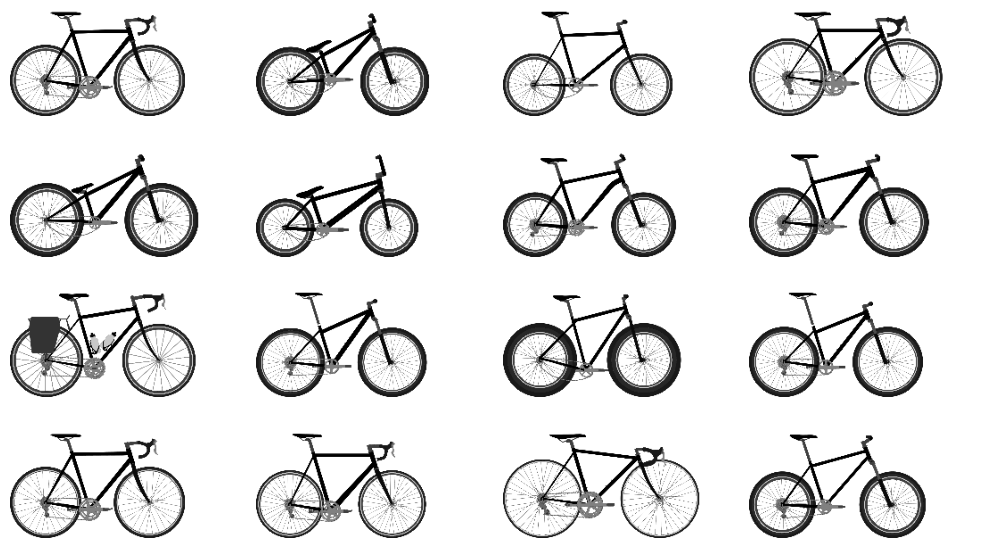

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray') # The images are single-channel (grayscale)
    ax.axis('off')
plt.tight_layout()
plt.show()

...examine some of the parametric data...

In [6]:
display(params)

,SSSIDECX3,SSSIDECX2,SSSIDECX1,SSSIDECY2,SSSIDECY1,STEMBENDS,FRONTROTORBOLTS,Shoe up angle,Down tube front diameter,LRTHICK,...,Top tube type OHCLASS: 0,Top tube type OHCLASS: 1,BRAZEonFDTYPE OHCLASS: FD9000F,BRAZEonFDTYPE OHCLASS: FD9070F,CSAUX3_MM_RATIO OHCLASS: 0,CSAUX3_MM_RATIO OHCLASS: 1,bottle SEATTUBE0 show OHCLASS: False,bottle SEATTUBE0 show OHCLASS: True,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True
0,65.5,131.2,306.0,-10.0,10.0,0,6,36,42.0,10,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,65.5,104.1,242.9,-10.0,10.0,0,6,36,38.1,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,65.5,165.3,385.7,-10.0,10.0,0,6,35,32.0,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,65.5,132.3,308.6,-10.0,10.0,0,6,35,32.0,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,65.5,143.6,335.2,-10.0,10.0,0,6,36,38.1,10,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,58.8,117.7,274.6,-10.0,10.0,0,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4508,65.5,75.8,189.4,15.0,30.0,1,6,36,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4509,65.5,130.4,304.2,-10.0,10.0,1,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4510,88.9,177.7,10.3,-10.0,10.0,1,6,39,38.1,10,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


...and have a look at the class data.

In [7]:
display(classes)

,BIKESTYLE
0,ROAD
1,DIRT_JUMP
2,POLO
3,ROAD
4,DIRT_JUMP
...,...
4507,COMMUTER
4508,MTB
4509,ROAD
4510,ROAD


We see that the class labels are individual strings. Now that we have had a look at the data, lets 1) scale our parametric data, 2) encode our class labels, 3) split the data.

In [8]:
# Threshold for minimum class size (e.g., classes with fewer than 10 instances will be removed)
min_class_size = 10

# 1. Normalize parametric data using StandardScaler
scaler = StandardScaler()
params_scaled = scaler.fit_transform(params)

# 2. Flatten classes to ensure it's a 1D array and count occurrences of each class
classes_flattened = np.ravel(classes)
unique_classes, class_counts = np.unique(classes_flattened, return_counts=True)

# 3. Filter classes with at least `min_class_size` instances
valid_classes = unique_classes[class_counts >= min_class_size]
valid_indices = np.isin(classes_flattened, valid_classes)

# 4. Filter parametric data, image data, and class labels based on valid classes
params_filtered = params_scaled[valid_indices]
images_filtered = images[valid_indices]
classes_filtered = classes_flattened[valid_indices]

# 5. Encode class labels from strings to integers using LabelEncoder
le = LabelEncoder()
classes_filtered_num = le.fit_transform(classes_filtered)

# 6. Split into training (90%) and test set (10%) using stratification
param_train, param_test, image_train, image_test, class_train, class_test = train_test_split(
    params_filtered, images_filtered, classes_filtered_num, test_size=0.1, random_state=42, stratify=classes_filtered_num
)

# 7. Split training set into training (80%) and validation set (10%, or 11.1% of remaining data)
param_train, param_val, image_train, image_val, class_train, class_val = train_test_split(
    param_train, image_train, class_train, test_size=0.111, random_state=42, stratify=class_train
)


In [9]:
# Set up common variables
param_size = param_train.shape[1]  # Number of columns in parametric data
num_classes = len(np.unique(class_train))  # Number of unique classes
image_height = image_train.shape[1]  # Height of the images
image_width = image_train.shape[2]   # Width of the images

Before we start training models, let us set up an evaluation function. We are trying to make this model agnostic. Since different models make predictions in different ways, we need to pass in a predict function. We will define this directly in the respective sections for neural networks and AutoGluon models so that you can run the sections independently.

In [10]:
def evaluate_model(model, predict_fn, val_data, test_data, label_encoder):
    """
    General evaluation function that works for any model.

    Args:
    - model: The model to evaluate (NN, AutoGluon Tabular, or AutoGluon Image).
    - predict_fn: A function that takes in the model and the data, and returns predictions and labels.
    - val_data: DataLoader or Pandas DataFrame for validation data.
    - test_data: DataLoader or Pandas DataFrame for test data.
    - label_encoder: Fitted LabelEncoder to map back to original class names.

    Returns:
    - None (prints accuracy, F1-score, and displays confusion matrices as heatmaps).
    """

    # Get predictions and labels using the provided prediction function
    val_preds, val_labels = predict_fn(model, val_data)
    test_preds, test_labels = predict_fn(model, test_data)

    # Calculate accuracy and F1-score for validation set
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    # Calculate accuracy and F1-score for test set
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    # Print accuracy and F1-score
    print(f'Validation Accuracy: {val_accuracy:.4f}, Validation F1-Score: {val_f1:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1:.4f}')

    # Decode integer labels back to original class names
    class_names = label_encoder.inverse_transform(np.unique(val_labels))

    # Sort classes by prevalence in the validation set
    class_counts = np.bincount(val_labels)  # Count the occurrences of each class
    sorted_indices = np.argsort(-class_counts)  # Sort in descending order of prevalence

    # Sort the confusion matrix and labels by class prevalence
    sorted_class_names = class_names[sorted_indices]

    # Create a figure with two subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot normalized confusion matrix for validation set
    val_conf_matrix = confusion_matrix(val_labels, val_preds, normalize='true')  # Normalize by row (class count)
    val_conf_matrix = val_conf_matrix[sorted_indices][:, sorted_indices]  # Sort rows and columns by prevalence
    sns.heatmap(val_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted_class_names, yticklabels=sorted_class_names,
                ax=axes[0], cbar=False, annot_kws={"size": 10})  # Reduce font size of the text annotations
    axes[0].set_title('Normalized Confusion Matrix - Validation Set', fontsize=14)
    axes[0].set_xlabel('Predicted Labels', fontsize=12)
    axes[0].set_ylabel('True Labels', fontsize=12)

    # Plot normalized confusion matrix for test set
    test_conf_matrix = confusion_matrix(test_labels, test_preds, normalize='true')  # Normalize by row (class count)
    test_conf_matrix = test_conf_matrix[sorted_indices][:, sorted_indices]  # Sort rows and columns by prevalence
    sns.heatmap(test_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted_class_names, yticklabels=sorted_class_names,
                ax=axes[1], cbar=False, annot_kws={"size": 10})  # Reduce font size of the text annotations
    axes[1].set_title('Normalized Confusion Matrix - Test Set', fontsize=14)
    axes[1].set_xlabel('Predicted Labels', fontsize=12)
    axes[1].set_ylabel('True Labels', fontsize=12)

    # Adjust layout to refine space between the subplots
    plt.tight_layout()
    plt.show()


# **Part 1 [2.155 and 2.156]: Classification with Custom Neural Networks**

Subsections:


*   1A: DNN
*   1B: CNN
*   1C: Hybrid DNN/CNN

## **Section 1A: Classification using Parameter Data: DNN**

First, we create a deep neural network. This should largely be review from Demo 5.

In [11]:
# Define DNN model for parametric data
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()

        # Define fully connected layers
        self.fc1 = nn.Linear(input_size, 128)  # Input size is the number of features in the parametric data
        self.fc2 = nn.Linear(128, 128)         # 128 inputs, 128 outputs
        self.fc3 = nn.Linear(128, 128)         # 128 inputs, 128 outputs
        self.fc4 = nn.Linear(128, num_classes) # Output size matches the number of classes

    def forward(self, x):
        # Pass through fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Output layer with no activation (logits)
        x = self.fc4(x)  # Output size is [batch x num_classes]
        return x

# Create a DNN model instance
model_dnn = DNN(input_size=param_size, num_classes=num_classes)
model_dnn.to(device)

# Print the model's architecture for reference
summary(model_dnn, input_size=(param_size,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         307,456
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                   [-1, 18]           2,322
Total params: 342,802
Trainable params: 342,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.31
Estimated Total Size (MB): 1.32
----------------------------------------------------------------


Ok, we'll create a training loop and a function to plot convergence. You've seen this stuff in Demo 5, but the details are explained in the comments.

One main change to note is that we are training using cross entropy loss, rather than mean squared error, since we are training a multiclass classification model here, rather than a regression model.

Another change is that we implement early stopping to the training if our model is not improving. If we see no improvement within `patience` epochs (default 5), we halt training. We also retain the best instance of the model found at any epoch.

We will reuse this training function for each of the neural networks in the demo.




In [12]:
import copy  # To make a deep copy of the model
from sklearn.metrics import f1_score

def train_model(model, train_loader, validation_loader, num_epochs=10, learning_rate=0.001, device=device, patience=5):
    """
    General-purpose function to train any model (DNN, CNN, or hybrid) using pre-created DataLoader objects.
    Implements early stopping based on validation F1 score, and retains the best model.

    Args:
    - model: The model to train (DNN, CNN, hybrid, etc.).
    - train_loader: DataLoader for the training data.
    - validation_loader: DataLoader for the validation data.
    - num_epochs: Number of training epochs (default: 10).
    - learning_rate: Learning rate for the optimizer (default: 0.001).
    - device: Device to run the model on ('cuda' or 'cpu').
    - patience: Number of epochs to wait for F1 score improvement before stopping (default: 3).

    Returns:
    - best_model: The model that had the best validation F1 score.
    - train_losses: List of training losses for each epoch.
    - val_losses: List of validation losses for each epoch.
    - train_f1_scores: List of F1 scores on the training set for each epoch.
    - val_f1_scores: List of F1 scores on the validation set for each epoch.
    """

    # Move model to the specified device (GPU or CPU)
    model = model.to(device)

    # Define loss function (CrossEntropyLoss for multi-class classification)
    criterion = nn.CrossEntropyLoss()

    # Define optimizer (Adam optimizer with specified learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store train and validation losses, and F1 scores
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Early stopping variables
    best_val_f1 = -float('inf')  # Initialize the best F1 score to a very low value
    epochs_without_improvement = 0  # Counter for epochs without improvement
    best_model = copy.deepcopy(model)  # Initialize the best model as a copy of the current model

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        # Using tqdm for the training loop progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch [{epoch + 1}/{num_epochs}]', leave=False)

        # Iterate over batches of training data
        for inputs, labels in train_loader_tqdm:
            inputs = inputs.to(device)  # Move inputs to device (GPU/CPU)
            labels = labels.to(device)  # Move labels to device (GPU/CPU)

            # Zero the gradients before the next update
            optimizer.zero_grad()

            # Forward pass: compute model outputs
            outputs = model(inputs)

            # Compute the loss for multi-class classification
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Perform a single optimization step (update model parameters)
            optimizer.step()

            # Accumulate loss over the batch
            running_loss += loss.item() * inputs.size(0)

            # Collect predictions and true labels for F1 score calculation
            _, preds = torch.max(outputs, 1)
            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())

            # Update tqdm progress bar with current loss
            train_loader_tqdm.set_postfix({'Train Loss': running_loss / len(train_loader.dataset)})

        # Calculate average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Calculate the F1 score for the training set (weighted)
        all_train_preds = np.concatenate(all_train_preds)
        all_train_labels = np.concatenate(all_train_labels)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_f1_scores.append(train_f1)

        # Validation loop (no gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute model outputs
                outputs = model(inputs)

                # Compute validation loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Collect predictions and true labels for F1 score calculation
                _, preds = torch.max(outputs, 1)
                all_val_preds.append(preds.cpu().numpy())
                all_val_labels.append(labels.cpu().numpy())

        # Calculate average validation loss for the epoch
        val_loss /= len(validation_loader.dataset)
        val_losses.append(val_loss)

        # Calculate the F1 score for the validation set (weighted)
        all_val_preds = np.concatenate(all_val_preds)
        all_val_labels = np.concatenate(all_val_labels)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_f1_scores.append(val_f1)

        # Print the train and validation loss and F1 score at the end of each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_loss:.4f} - Validation Loss: {val_loss:.4f} - Train F1: {train_f1:.4f} - Validation F1: {val_f1:.4f}')

        # Early stopping logic: Check if validation F1 improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1  # Update the best F1 score
            epochs_without_improvement = 0  # Reset the counter
            best_model = copy.deepcopy(model)  # Save the best model
        else:
            epochs_without_improvement += 1  # Increment the counter

        # Check if we need to stop early
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. No improvement in F1 score for {patience} consecutive epochs.")
            break

    print("Training complete.")

    # Return the best model and the recorded training losses, validation losses, and F1 scores
    return best_model, train_losses, val_losses, train_f1_scores, val_f1_scores



def plot_convergence(train_losses, val_losses, train_f1_scores, val_f1_scores):
    """
    Function to plot the training and validation loss convergence over epochs,
    along with the training and validation F1 scores.

    Args:
    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    - train_f1_scores: List of training F1 scores per epoch.
    - val_f1_scores: List of validation F1 scores per epoch.
    """

    # Create subplots: one for loss and one for F1 score
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training and validation losses on the first subplot
    ax1.plot(train_losses, label='Train Loss', color="black")
    ax1.plot(val_losses, label='Validation Loss', color="red")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Convergence')
    ax1.legend(loc='upper right')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot training and validation F1 scores on the second subplot
    ax2.plot(train_f1_scores, label='Train F1 Score', color="blue")
    ax2.plot(val_f1_scores, label='Validation F1 Score', color="green")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Score Convergence')
    ax2.legend(loc='lower right')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    # Adjust layout to add space between plots
    plt.tight_layout()

    # Show the plots
    plt.show()


Here is the predict function for the neural nets. Notably, it expects a dataloader when making predictions.

In [13]:
def nn_predict_fn(model, loader):
    all_preds = []
    all_labels = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.append(preds.cpu().numpy())  # Move predictions to CPU and append
            all_labels.append(labels.cpu().numpy())  # Move labels to CPU and append
    return np.concatenate(all_preds), np.concatenate(all_labels)


Epoch [1/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/20] - Train Loss: 1.5481 - Validation Loss: 1.1716 - Train F1: 0.4977 - Validation F1: 0.6094


Epoch [2/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/20] - Train Loss: 0.7698 - Validation Loss: 0.9763 - Train F1: 0.7274 - Validation F1: 0.6871


Epoch [3/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/20] - Train Loss: 0.4430 - Validation Loss: 1.1025 - Train F1: 0.8515 - Validation F1: 0.7095


Epoch [4/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/20] - Train Loss: 0.2446 - Validation Loss: 1.2126 - Train F1: 0.9262 - Validation F1: 0.7061


Epoch [5/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/20] - Train Loss: 0.1410 - Validation Loss: 1.3237 - Train F1: 0.9592 - Validation F1: 0.7271


Epoch [6/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6/20] - Train Loss: 0.1211 - Validation Loss: 1.4650 - Train F1: 0.9659 - Validation F1: 0.7150


Epoch [7/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7/20] - Train Loss: 0.0967 - Validation Loss: 1.5758 - Train F1: 0.9692 - Validation F1: 0.7336


Epoch [8/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8/20] - Train Loss: 0.0672 - Validation Loss: 1.6914 - Train F1: 0.9830 - Validation F1: 0.7266


Epoch [9/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9/20] - Train Loss: 0.0448 - Validation Loss: 1.7946 - Train F1: 0.9867 - Validation F1: 0.7119


Epoch [10/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10/20] - Train Loss: 0.0332 - Validation Loss: 1.7941 - Train F1: 0.9911 - Validation F1: 0.7276


Epoch [11/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11/20] - Train Loss: 0.0263 - Validation Loss: 1.9433 - Train F1: 0.9933 - Validation F1: 0.7059


Epoch [12/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12/20] - Train Loss: 0.0224 - Validation Loss: 1.8675 - Train F1: 0.9931 - Validation F1: 0.7179
Early stopping triggered. No improvement in F1 score for 5 consecutive epochs.
Training complete.


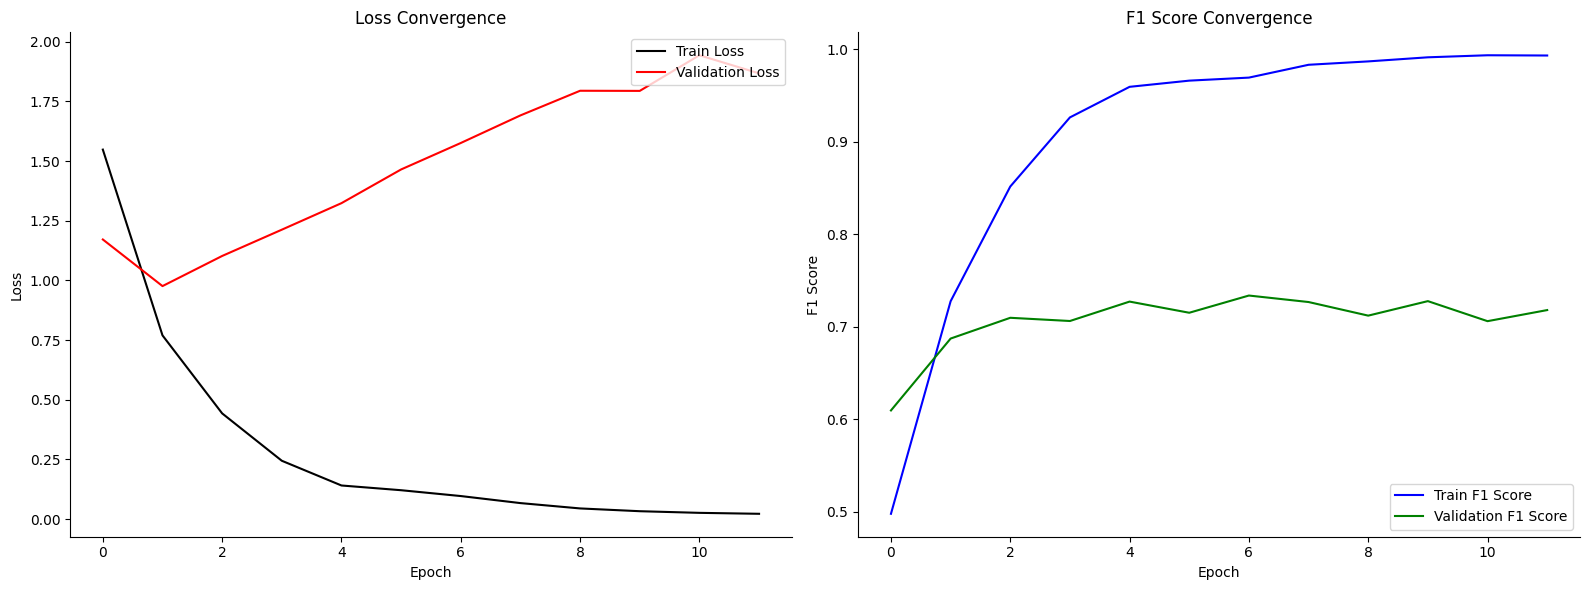

Validation Accuracy: 0.7450, Validation F1-Score: 0.7336
Test Accuracy: 0.7279, Test F1-Score: 0.7087


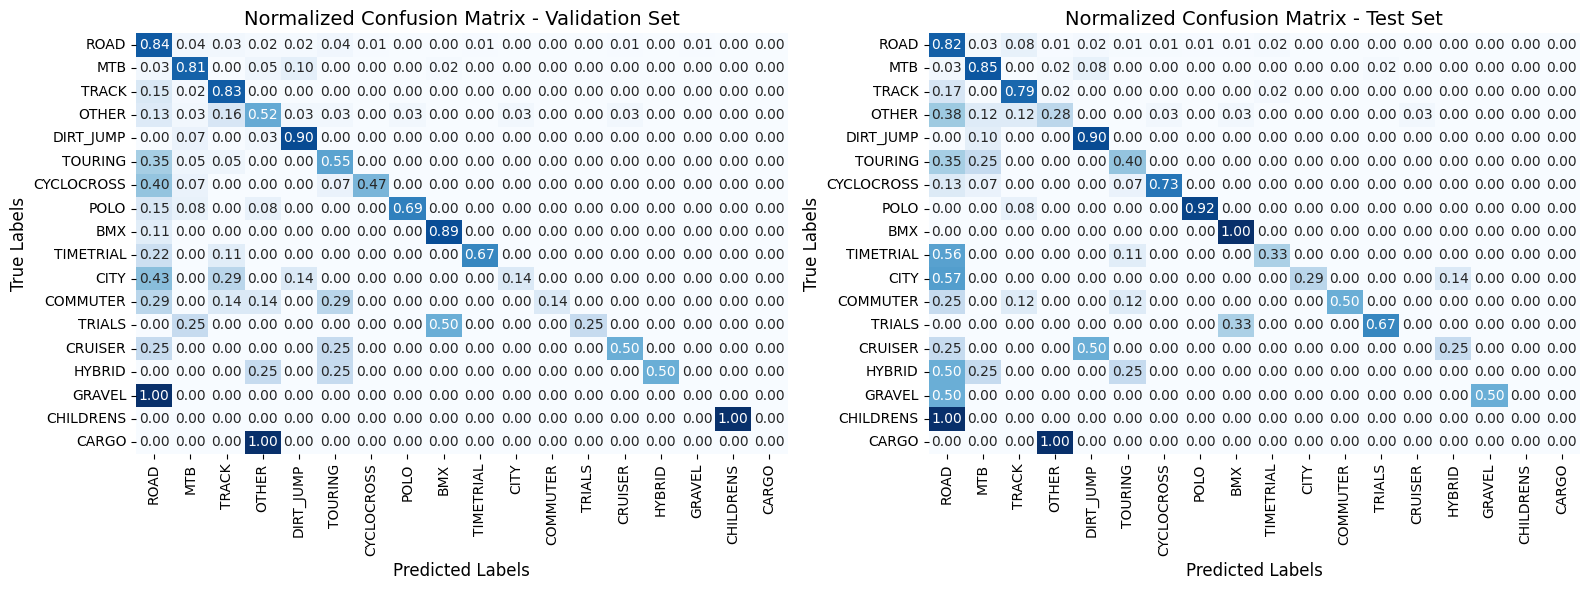

In [14]:
# Creating DataLoaders for DNN (parametric data)
dnn_train_loader = DataLoader(TensorDataset(torch.tensor(param_train, dtype=torch.float32), torch.tensor(class_train, dtype=torch.long)), batch_size=32, shuffle=True)
dnn_val_loader = DataLoader(TensorDataset(torch.tensor(param_val, dtype=torch.float32), torch.tensor(class_val, dtype=torch.long)), batch_size=32, shuffle=False)
dnn_test_loader = DataLoader(TensorDataset(torch.tensor(param_test, dtype=torch.float32), torch.tensor(class_test, dtype=torch.long)), batch_size=32, shuffle=False)

# Training the DNN model
model_dnn_best, train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(model_dnn, dnn_train_loader, dnn_val_loader, num_epochs=20, learning_rate=0.001, device=device)

# Plotting the convergence of the model
plot_convergence(train_losses, val_losses, train_f1_scores, val_f1_scores)

# Evaluating the DNN model
evaluate_model(model_dnn_best, nn_predict_fn, dnn_val_loader, dnn_test_loader, le)

Interestingly, we see that increasing validation loss does not necessarily mean poorer F1 score over time.

## **Section 1B: Classification using Image Data: CNN**
Now, we train a CNN model. Again, this should be largely review from the previous demo.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self, num_classes):  # Define all the layers here
        super(CNN, self).__init__()

        # All pooling will use 2x2 window and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Conv layer: 1 input channel (grayscale), 4 output channels, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

        # Second Conv layer: 4 input channels, 8 output channels, kernel size 3x3, stride 1, padding 1
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)

        # Third Conv layer: 8 input channels, 16 output channels, kernel size 3x3, stride 1, padding 1
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # Fourth Conv layer: 16 input channels, 32 output channels, kernel size 3x3, stride 1, padding 1
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Operation to flatten the images into a vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        # Input size to the first fully connected layer is 32 * 7 * 16 (after the final pooling layer)
        self.fc1 = nn.Linear(32 * 7 * 16, 128)  # Adjusted to match the output size after conv4 and pooling
        self.fc2 = nn.Linear(128, num_classes)   # Output layer for num_classes

    def forward(self, x):  # Call all the layers in this function
        # Reshape the input to ensure it has the correct channel dimension: [batch x 1 x 120 x 260]
        if len(x.shape) == 3:  # Input is [batch x 120 x 260]
            x = x.unsqueeze(1)  # Add channel dimension -> [batch x 1 x 120 x 260]

        # Convolve, then pass through ReLU, then pooling
        x = F.relu(self.conv1(x))  # [batch x 4 x 120 x 260]
        x = self.pool(x)  # [batch x 4 x 60 x 130]

        x = F.relu(self.conv2(x))  # [batch x 8 x 60 x 130]
        x = self.pool(x)  # [batch x 8 x 30 x 65]

        x = F.relu(self.conv3(x))  # [batch x 16 x 30 x 65]
        x = self.pool(x)  # [batch x 16 x 15 x 32]

        x = F.relu(self.conv4(x))  # [batch x 32 x 15 x 32]
        x = self.pool(x)  # [batch x 32 x 7 x 16]

        x = self.flatten(x)  # Flatten for the fully connected layer [batch x 32 * 7 * 16 = 3,584]

        # Pass through fully connected layers with ReLU
        x = F.relu(self.fc1(x))  # [batch x 128]

        # Final fully connected layer with no activation (logits output for classification)
        x = self.fc2(x)  # Output layer with num_classes outputs [batch x num_classes]
        return x

# Create a CNN model instance
model_cnn = CNN(num_classes=num_classes)
model_cnn.to(device)

# Print the model's architecture
summary(model_cnn, input_size=(1, 120, 260))  # Input size for 120x260 grayscale images with 1 channel


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 120, 260]              40
         MaxPool2d-2           [-1, 4, 60, 130]               0
            Conv2d-3           [-1, 8, 60, 130]             296
         MaxPool2d-4            [-1, 8, 30, 65]               0
            Conv2d-5           [-1, 16, 30, 65]           1,168
         MaxPool2d-6           [-1, 16, 15, 32]               0
            Conv2d-7           [-1, 32, 15, 32]           4,640
         MaxPool2d-8            [-1, 32, 7, 16]               0
           Flatten-9                 [-1, 3584]               0
           Linear-10                  [-1, 128]         458,880
           Linear-11                   [-1, 18]           2,322
Total params: 467,346
Trainable params: 467,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.12
Forward/

Epoch [1/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/20] - Train Loss: 2.0873 - Validation Loss: 1.8408 - Train F1: 0.2510 - Validation F1: 0.3101


Epoch [2/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/20] - Train Loss: 1.5435 - Validation Loss: 1.4081 - Train F1: 0.4635 - Validation F1: 0.5462


Epoch [3/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/20] - Train Loss: 1.2618 - Validation Loss: 1.2657 - Train F1: 0.5690 - Validation F1: 0.5664


Epoch [4/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/20] - Train Loss: 1.1819 - Validation Loss: 1.2011 - Train F1: 0.6006 - Validation F1: 0.5960


Epoch [5/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/20] - Train Loss: 1.1144 - Validation Loss: 1.1406 - Train F1: 0.6252 - Validation F1: 0.5842


Epoch [6/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6/20] - Train Loss: 1.0579 - Validation Loss: 1.1077 - Train F1: 0.6434 - Validation F1: 0.6412


Epoch [7/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7/20] - Train Loss: 1.0019 - Validation Loss: 1.1182 - Train F1: 0.6600 - Validation F1: 0.6184


Epoch [8/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8/20] - Train Loss: 0.9640 - Validation Loss: 1.1299 - Train F1: 0.6750 - Validation F1: 0.6340


Epoch [9/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9/20] - Train Loss: 0.9076 - Validation Loss: 1.0809 - Train F1: 0.6887 - Validation F1: 0.6274


Epoch [10/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10/20] - Train Loss: 0.8379 - Validation Loss: 1.1438 - Train F1: 0.7110 - Validation F1: 0.6376


Epoch [11/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11/20] - Train Loss: 0.7891 - Validation Loss: 1.1283 - Train F1: 0.7264 - Validation F1: 0.6327
Early stopping triggered. No improvement in F1 score for 5 consecutive epochs.
Training complete.


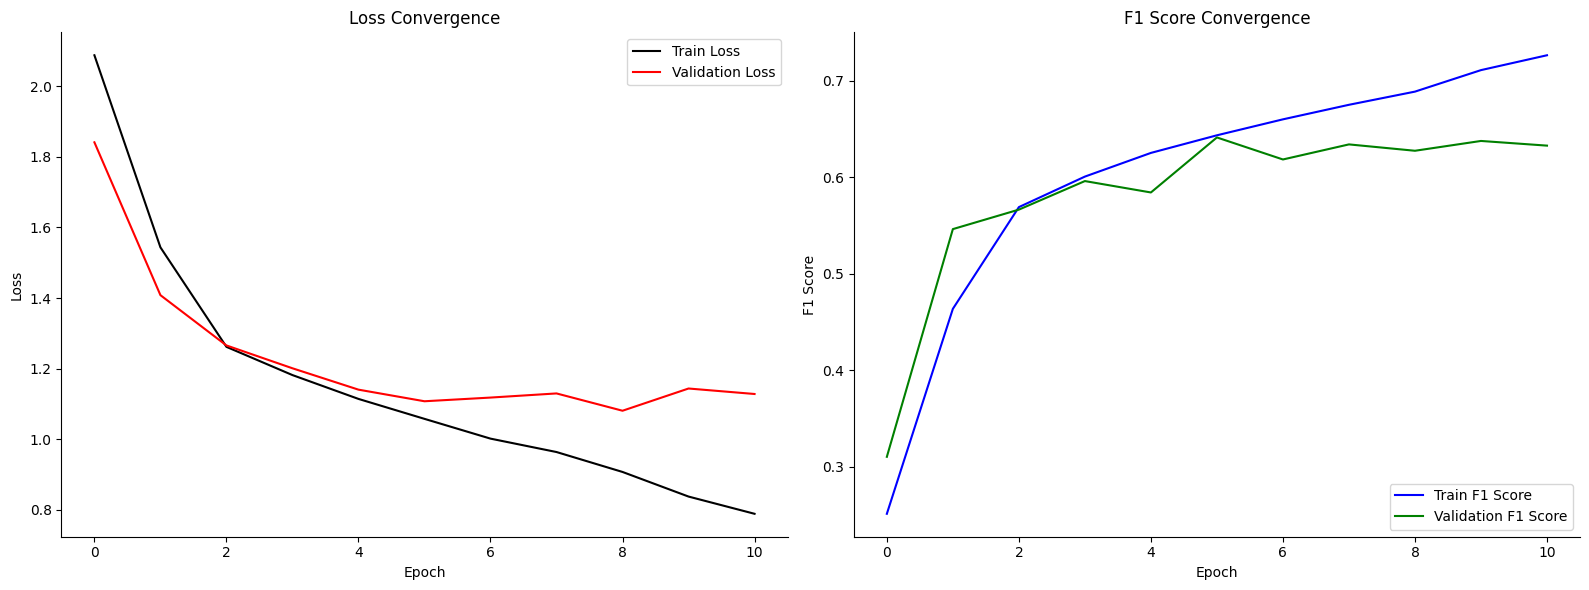

Validation Accuracy: 0.6652, Validation F1-Score: 0.6412
Test Accuracy: 0.6659, Test F1-Score: 0.6305


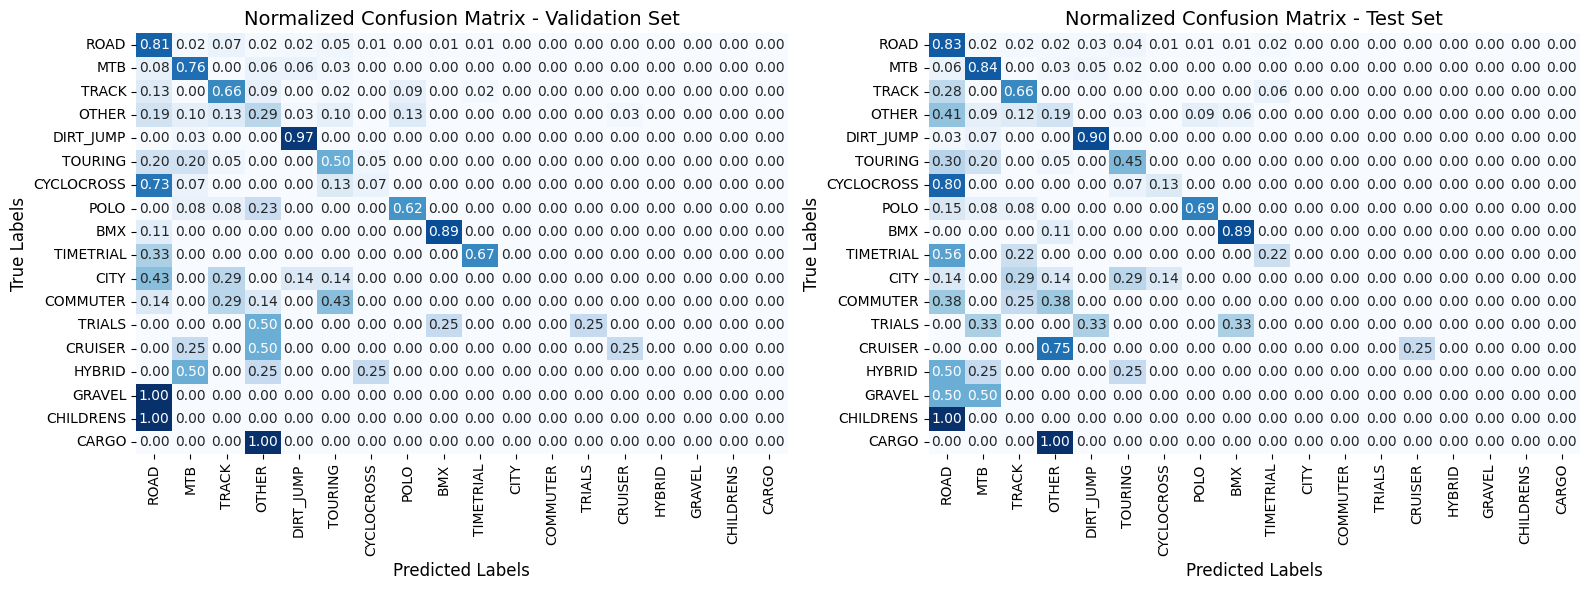

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming image_train, image_val, image_test, class_train, class_val, class_test are already defined

# Create DataLoaders for the CNN model using image data and class labels
cnn_train_loader = DataLoader(TensorDataset(torch.tensor(image_train, dtype=torch.float32), torch.tensor(class_train, dtype=torch.long)), batch_size=32, shuffle=True)
cnn_val_loader = DataLoader(TensorDataset(torch.tensor(image_val, dtype=torch.float32), torch.tensor(class_val, dtype=torch.long)), batch_size=32, shuffle=False)
cnn_test_loader = DataLoader(TensorDataset(torch.tensor(image_test, dtype=torch.float32), torch.tensor(class_test, dtype=torch.long)), batch_size=32, shuffle=False)

# Training the CNN model
model_cnn_best, train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(model_cnn, cnn_train_loader, cnn_val_loader, num_epochs=20, learning_rate=0.001, device=device)

# Plotting the convergence of the model
plot_convergence(train_losses, val_losses, train_f1_scores, val_f1_scores)

# Evaluating the CNN model
evaluate_model(model_cnn_best, nn_predict_fn, cnn_val_loader, cnn_test_loader, le)



## **Section 1C: Classification using Parametric and Image Data: Hybrid NN**

In this section, we will set up a neural network to make predictions using both the parametric and image data. The general strategy is to pass the image data through some convolution layers as the parametric data is passed through deep layers. Then we will concatenate the outputs of these sub-networks, pass them through a couple more deep layers, then make a final prediction.

There are a few ways to set this up. Instead of only passing in one dataset, now we need to feed in two. The nn.module.forward function can actually be set up with multiple inputs. However, to keep the automated model summaries functioning correctly and to reuse the training code from before, we will instead opt for a bit of a creative solution by flattening the images and concatenating them with the parametric data and feeding them into the model as one block of data. Note that this is only a logistical reorganization and that we don't actually learn on the concatenated data. The model re-separates this data before passing them into any of the layers.

In [17]:
class HybridDNN(nn.Module):
    def __init__(self, param_size, image_height, image_width, num_classes):
        super(HybridDNN, self).__init__()

        # Store image dimensions
        self.image_height = image_height
        self.image_width = image_width

        # CNN Branch for image data
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First Conv layer: 1 input channel (grayscale), 4 output channels, kernel size 3x3, stride 1, padding 1
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)  # Output: [batch x 4 x 120 x 260]

        # Second Conv layer: 4 input channels, 8 output channels
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)  # Output: [batch x 8 x 60 x 130]

        # Third Conv layer: 8 input channels, 16 output channels
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # Output: [batch x 16 x 30 x 65]

        # Fourth Conv layer: 16 input channels, 32 output channels
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: [batch x 32 x 15 x 32]

        # Flatten layer for CNN output
        self.flatten = nn.Flatten()

        # Fully connected layer for CNN branch (after flattening 32 x 7 x 16 = 3584)
        self.fc_cnn = nn.Linear(32 * 7 * 16, 64)  # Output from CNN -> [batch x 64]

        # DNN Branch for parametric data
        self.fc1_dnn = nn.Linear(param_size, 64)  # Fully connected layer for parametric data -> [batch x 64]
        self.fc2_dnn = nn.Linear(64, 64)  # Another fully connected layer for parametric data -> [batch x 64]

        # Combined branch (after merging CNN and DNN outputs)
        self.fc_combined1 = nn.Linear(64 + 64, 64)  # Combined layer -> [batch x 64]
        self.fc_combined2 = nn.Linear(64, num_classes)  # Output layer -> [batch x num_classes]

    def forward(self, x):
        # Split the combined input into parametric data and flattened image data
        param_data = x[:, :param_size]  # First part is parametric data
        image_data = x[:, param_size:]  # Remaining part is flattened image data

        # Reshape the image data back to [batch, 1, height, width]
        image_data = image_data.view(-1, 1, self.image_height, self.image_width)

        # CNN branch
        x1 = F.relu(self.conv1(image_data))  # [batch x 4 x 120 x 260]
        x1 = self.pool(x1)  # [batch x 4 x 60 x 130]

        x1 = F.relu(self.conv2(x1))  # [batch x 8 x 60 x 130]
        x1 = self.pool(x1)  # [batch x 8 x 30 x 65]

        x1 = F.relu(self.conv3(x1))  # [batch x 16 x 30 x 65]
        x1 = self.pool(x1)  # [batch x 16 x 15 x 32]

        x1 = F.relu(self.conv4(x1))  # [batch x 32 x 15 x 32]
        x1 = self.pool(x1)  # [batch x 32 x 7 x 16]

        x1 = self.flatten(x1)  # Flatten the CNN output -> [batch x 32 * 7 * 16 = 3584]
        x1 = F.relu(self.fc_cnn(x1))  # Pass through fully connected CNN layer -> [batch x 64]

        # DNN branch (parametric data)
        x2 = F.relu(self.fc1_dnn(param_data))  # Fully connected DNN layer -> [batch x 64]
        x2 = F.relu(self.fc2_dnn(x2))  # Fully connected DNN layer -> [batch x 64]

        # Combine CNN and DNN branches
        x = torch.cat((x1, x2), dim=1)  # Concatenate along the feature dimension -> [batch x 64 + 64 = 128]

        # Pass through combined fully connected layers
        x = F.relu(self.fc_combined1(x))  # Combined layer -> [batch x 64]
        x = self.fc_combined2(x)  # Output layer -> [batch x num_classes]

        return x

# Initialize the hybrid model
model_hybrid = HybridDNN(param_size=param_size, image_height=image_height, image_width=image_width, num_classes=num_classes)
model_hybrid.to(device)

# Print the model architecture for reference
combined_input_size = param_size + (1 * image_height * image_width)  # Size after concatenating flattened image and parametric data
summary(model_hybrid, (combined_input_size,))  # Single input after concatenation



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 120, 260]              40
         MaxPool2d-2           [-1, 4, 60, 130]               0
            Conv2d-3           [-1, 8, 60, 130]             296
         MaxPool2d-4            [-1, 8, 30, 65]               0
            Conv2d-5           [-1, 16, 30, 65]           1,168
         MaxPool2d-6           [-1, 16, 15, 32]               0
            Conv2d-7           [-1, 32, 15, 32]           4,640
         MaxPool2d-8            [-1, 32, 7, 16]               0
           Flatten-9                 [-1, 3584]               0
           Linear-10                   [-1, 64]         229,440
           Linear-11                   [-1, 64]         153,728
           Linear-12                   [-1, 64]           4,160
           Linear-13                   [-1, 64]           8,256
           Linear-14                   

Our dataloader setup is now slightly more elaborate, since we need to concatenate all the image and parametric data together.

Epoch [1/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/20] - Train Loss: 1.6586 - Validation Loss: 1.2763 - Train F1: 0.4527 - Validation F1: 0.5461


Epoch [2/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/20] - Train Loss: 0.9819 - Validation Loss: 1.1010 - Train F1: 0.6471 - Validation F1: 0.6523


Epoch [3/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/20] - Train Loss: 0.6550 - Validation Loss: 1.0834 - Train F1: 0.7834 - Validation F1: 0.6907


Epoch [4/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/20] - Train Loss: 0.4205 - Validation Loss: 1.2026 - Train F1: 0.8633 - Validation F1: 0.6870


Epoch [5/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/20] - Train Loss: 0.2735 - Validation Loss: 1.2276 - Train F1: 0.9187 - Validation F1: 0.7044


Epoch [6/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6/20] - Train Loss: 0.1860 - Validation Loss: 1.3553 - Train F1: 0.9471 - Validation F1: 0.7066


Epoch [7/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7/20] - Train Loss: 0.1197 - Validation Loss: 1.4960 - Train F1: 0.9675 - Validation F1: 0.7137


Epoch [8/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8/20] - Train Loss: 0.0869 - Validation Loss: 1.5503 - Train F1: 0.9752 - Validation F1: 0.7014


Epoch [9/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9/20] - Train Loss: 0.0718 - Validation Loss: 1.5837 - Train F1: 0.9828 - Validation F1: 0.7144


Epoch [10/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10/20] - Train Loss: 0.0472 - Validation Loss: 1.7245 - Train F1: 0.9889 - Validation F1: 0.7175


Epoch [11/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11/20] - Train Loss: 0.0325 - Validation Loss: 1.8682 - Train F1: 0.9908 - Validation F1: 0.7082


Epoch [12/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12/20] - Train Loss: 0.0276 - Validation Loss: 1.8230 - Train F1: 0.9928 - Validation F1: 0.7134


Epoch [13/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13/20] - Train Loss: 0.0293 - Validation Loss: 1.8722 - Train F1: 0.9925 - Validation F1: 0.7177


Epoch [14/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14/20] - Train Loss: 0.0270 - Validation Loss: 1.8897 - Train F1: 0.9928 - Validation F1: 0.7187


Epoch [15/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15/20] - Train Loss: 0.0262 - Validation Loss: 1.9029 - Train F1: 0.9917 - Validation F1: 0.7161


Epoch [16/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16/20] - Train Loss: 0.0251 - Validation Loss: 2.0297 - Train F1: 0.9931 - Validation F1: 0.6955


Epoch [17/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17/20] - Train Loss: 0.0286 - Validation Loss: 2.1545 - Train F1: 0.9920 - Validation F1: 0.7002


Epoch [18/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18/20] - Train Loss: 0.0336 - Validation Loss: 2.1430 - Train F1: 0.9908 - Validation F1: 0.7023


Epoch [19/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19/20] - Train Loss: 0.0369 - Validation Loss: 2.1740 - Train F1: 0.9897 - Validation F1: 0.7195


Epoch [20/20]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20/20] - Train Loss: 0.0406 - Validation Loss: 2.3576 - Train F1: 0.9870 - Validation F1: 0.7027
Training complete.


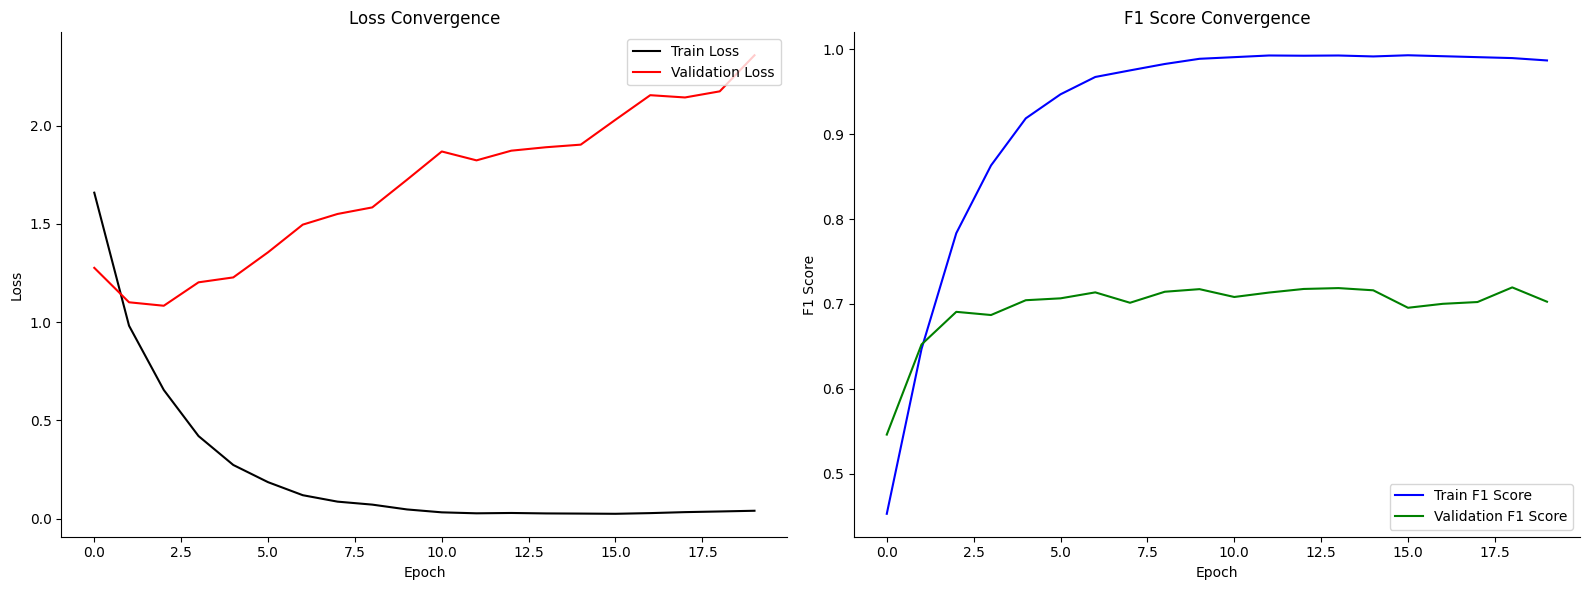

Validation Accuracy: 0.7317, Validation F1-Score: 0.7195
Test Accuracy: 0.7345, Test F1-Score: 0.7264


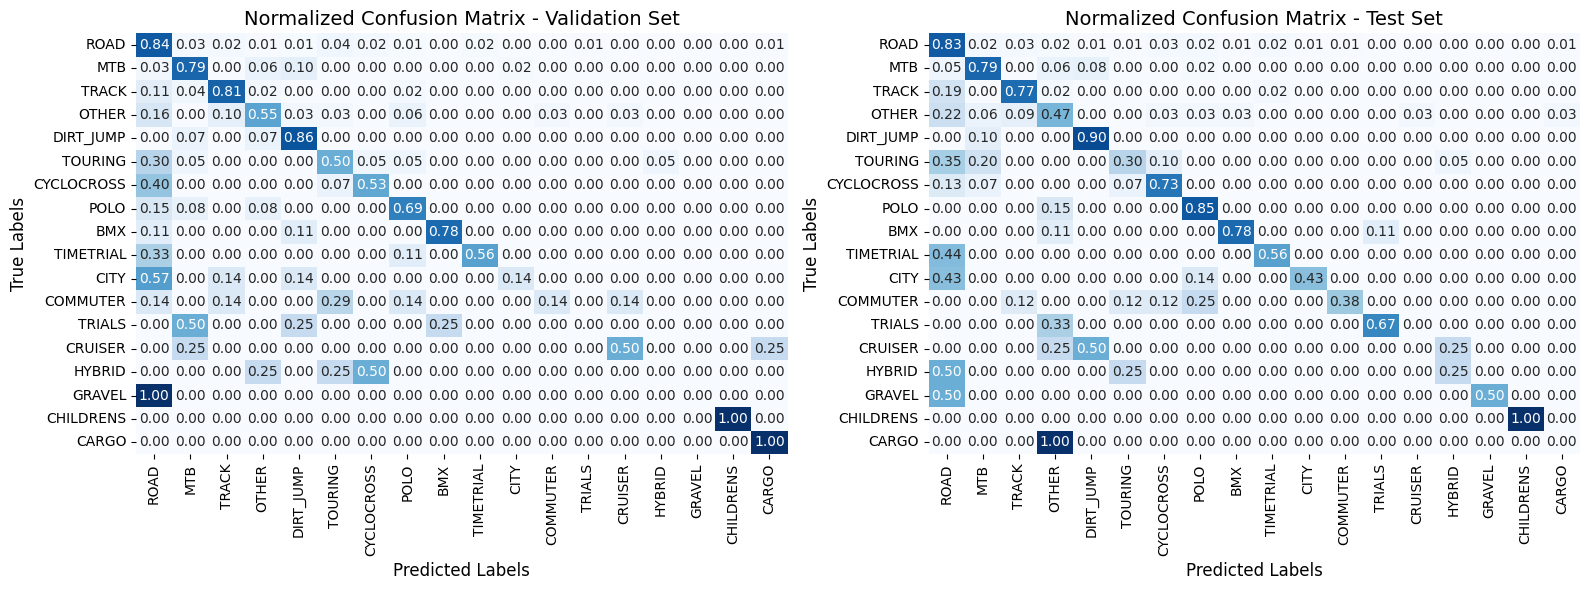

In [18]:
# Flatten the images and concatenate with parametric data
image_train_flattened = image_train.reshape(image_train.shape[0], -1)  # Flatten each image
image_val_flattened = image_val.reshape(image_val.shape[0], -1)
image_test_flattened = image_test.reshape(image_test.shape[0], -1)

# Concatenate the parametric data and flattened image data
train_data_combined = np.concatenate((param_train, image_train_flattened), axis=1)
val_data_combined = np.concatenate((param_val, image_val_flattened), axis=1)
test_data_combined = np.concatenate((param_test, image_test_flattened), axis=1)

# Create DataLoaders for the combined input
hybrid_train_loader = DataLoader(TensorDataset(torch.tensor(train_data_combined, dtype=torch.float32), torch.tensor(class_train, dtype=torch.long)), batch_size=32, shuffle=True)
hybrid_val_loader = DataLoader(TensorDataset(torch.tensor(val_data_combined, dtype=torch.float32), torch.tensor(class_val, dtype=torch.long)), batch_size=32, shuffle=False)
hybrid_test_loader = DataLoader(TensorDataset(torch.tensor(test_data_combined, dtype=torch.float32), torch.tensor(class_test, dtype=torch.long)), batch_size=32, shuffle=False)


# Create DataLoaders for the hybrid model using image data, parametric data, and class labels
hybrid_train_loader = DataLoader(TensorDataset(torch.tensor(train_data_combined, dtype=torch.float32), torch.tensor(class_train, dtype=torch.long)), batch_size=32, shuffle=True)
hybrid_val_loader = DataLoader(TensorDataset(torch.tensor(val_data_combined, dtype=torch.float32), torch.tensor(class_val, dtype=torch.long)), batch_size=32, shuffle=False)
hybrid_test_loader = DataLoader(TensorDataset(torch.tensor(test_data_combined, dtype=torch.float32), torch.tensor(class_test, dtype=torch.long)), batch_size=32, shuffle=False)

# Train the hybrid model
model_hybrid_best, train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(model_hybrid, hybrid_train_loader, hybrid_val_loader, num_epochs=20, learning_rate=0.001, device=device)

# Plotting the convergence of the model
plot_convergence(train_losses, val_losses, train_f1_scores, val_f1_scores)

# Evaluate the hybrid model
evaluate_model(model_hybrid_best, nn_predict_fn, hybrid_val_loader, hybrid_test_loader, le)


We generally see that the hybrid NN has a slight edge over either of the unimodal predictors.

## **Part 1 Reflection Questions:**
1. **Knowledge Check.** Please look into Pytorch's [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to understand what the input parameters do. As an exercise, consider the following: I have a batch of 64 RGB (3 channel) 32x32 images (64x3x32x32). I apply a 2D convolution with 16 output channels, kernel size 5, stride size 2, and padding of 1, then apply a pooling with kernel size 3, stride size 2, and padding 0, what final output dimension should I expect (including batch size). How many model parameters are associated with the above operations? [Here](https://www.geeksforgeeks.org/how-to-calculate-the-number-of-parameters-in-cnn/) is a nice resource to calculate parameter counts. Write code to verify.

2. **Model Architecture Exercise.** Rebuild the hybrid NN model to shrink the model to have between 200k and 250k parameters. We encourage you to manually calculate the parameter counts, rather than doing guess and check using the model summary. Once you have a design that you think has an appropriate number of parameters, please code up the model and verify that the summary agrees without calculations. Retry if necessary.

3. **Multimodal Ensembling.** Discuss how the multimodal approach in this code compares to a hypothetical ensemble of DNNs and CNNs. What are some advantages of this approach? Give a concrete physical example in which such a hybrid multimodal neural network may be able to learn something that an simple weighted ensemble of unimodal predictors couldnt. Theorize how to set up other hybrid neural networks or multimodal deep learning approaches.



# **Part 2 [2.156 only]: Classification with AutoGluon**

As you can see, setting up neural networks requires a lot of decision making (layers, filter sizes, etc). In practice, it is hard to be confident in these choices. Therefore, let's try out AutoGluon to see if it can do this for us.  

Subsections:

*   2A: AutoGluon Tabular
*   2B: AutoGluon Image
*   2C: AutoGluon Multimodal

**You may run out of RAM in colab, attempting to run this section. If so, please restart, run all the cells up to Part 1, skip part 1, then continue running here.**

**Note that we are significantly bottlenecking AutoGluon's performance here to enable it to train in colab. With these bottlenecks, AutoGluon does not perform well. Without restrictions, we expect AutoGluon to perform much better**

In [19]:
!mamba install -c conda-forge autogluon "pytorch=*=cuda*" torchaudio -y


Looking for: ['autogluon', 'pytorch=[build=cuda*]', 'torchaudio']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



## **Section 2A: Classification using AutoGluon Tabular**

One of the ways to pass tabular data to AutoGluon is in a pandas DataFrame. Instead of passing in a set of X values and Y values as is common in many predictive models (scikit-learn style), Autogluon expects one dataset with columns labeled and expects one of these columns to be specified as the column to predict. Therefore, we need to concatenate our data (see below where we add a column called 'label' containing our labels). We then specify label='label' when initializing the TabularPredictor.

We cut off training at 10 minutes, but autogluon tabular will do better with ~30 minutes on this problem. If you have the time, consider running it without the time limit.

In [ ]:
# Convert parametric data (train, validation, and test) to Pandas DataFrames
train_data = pd.DataFrame(param_train, columns=[f'feature_{i}' for i in range(param_train.shape[1])])
train_data['label'] = class_train  # Add class labels as a column

val_data = pd.DataFrame(param_val, columns=[f'feature_{i}' for i in range(param_val.shape[1])])
val_data['label'] = class_val

test_data = pd.DataFrame(param_test, columns=[f'feature_{i}' for i in range(param_test.shape[1])])
test_data['label'] = class_test

# Initialize AutoGluon TabularPredictor for classification
model_AG_tab = TabularPredictor(label='label', problem_type='multiclass').fit(train_data, time_limit=600) #set a time limit of 600 seconds

# Create predict function for use in the evaluation code
def autogluon_tabular_predict_fn(model, data):
    preds = model.predict(data.drop(columns=['label'])).to_numpy()  # Get predictions as numpy array
    labels = data['label'].to_numpy()  # Extract actual labels
    return preds, labels

# Evaluate the AutoGluon model using the unified evaluate_model function
evaluate_model(model_AG_tab, autogluon_tabular_predict_fn, val_data, test_data, le)

No path specified. Models will be saved in: "AutogluonModels/ag-20241031_132205"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       3.52 GB / 12.67 GB (27.8%)
Disk Space Avail:   65.32 GB / 112.64 GB (58.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fa

## **Part 2 Reflection Questions:**
1. Take a look at the AutoGluon Tabular [documentation](https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html). What happens when we only allow AutoGluon to use weak predictors (knn, dtrees, etc.)? Describe changes in performance and speed.
2. Please familiarize yourself with the AutoGluon Image and Multimodal Predictors below. If you have some modest compute available, we recommend that you try downloading the notebook and running them locally, as they can take hours to train well in colab. By running the models, try to understand how they work. Comment on any learnings.

## **Section 2B (Bonus): Classification using AutoGluon Image**
As of now, Autogluon has a general multimodal predictor framework for any non-tabular predictions. For pure image prediction, counterintuitively, we will use the multimodalpredictor.

Currently AutoGluon does not support any mechanism to pass in images as an array. Instead, to apply AutoGluon to images, we actually need to write images into individual files and provide the filepaths to autogluon, which will load the images internally. We write some code to do this.

In [ ]:
# Directories to save images
train_img_dir = 'images/train/'
val_img_dir = 'images/val/'
test_img_dir = 'images/test/'

# Create directories if they don't exist
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)

# Function to save images
def save_images(image_data, labels, directory):
    file_paths = []
    # Wrap the loop with tqdm for progress tracking
    for i, (image, label) in tqdm(enumerate(zip(image_data, labels)), total=len(image_data), desc=f"Saving images to {directory}"):
        file_path = os.path.join(directory, f'image_{i}.png')
        # Save the image as a PNG file (convert to 0-255 grayscale format if necessary)
        cv2.imwrite(file_path, (image * 255).astype('uint8'))
        file_paths.append(file_path)
    return file_paths

# Save train, val, and test images
train_image_paths = save_images(image_train, class_train, train_img_dir)
val_image_paths = save_images(image_val, class_val, val_img_dir)
test_image_paths = save_images(image_test, class_test, test_img_dir)

# Create DataFrames for AutoGluon
train_data = pd.DataFrame({'image': train_image_paths, 'label': class_train})
val_data = pd.DataFrame({'image': val_image_paths, 'label': class_val})
test_data = pd.DataFrame({'image': test_image_paths, 'label': class_test})



Time to train! Although it somewhat defeats the purpose of AutoML, we have to tinker with the hyperparameters here to make it runnable in colab. Therefore, we specifically select a small model which is a bit more manageable than the default model that AG uses. We also set a training time limit of 5 minutes. Training for less than 30 minutes will pretty much result in junk. A very strong model may require multiple hours of training.

In [ ]:
# Initialize the MultiModalPredictor for image classification
image_predictor = MultiModalPredictor(label='label', problem_type='multiclass')

# Train the model
image_predictor.fit(
    train_data=train_data,  # Pass the DataFrame with image paths and labels
    tuning_data=val_data,   # Validation data for tuning
    presets='best_quality',  # Preset for high accuracy
    time_limit=300, #SET TRAINING TIME HERE (measured in seconds)
    hyperparameters={
        'model.names': ['timm_image_model'],
        'model.timm_image_model.checkpoint_name': 'mobilenetv2_100',
    }
)

def autogluon_image_predict_fn(model, data):
    preds = model.predict(data.drop(columns=['label'])).to_numpy()  # Get predictions as numpy array
    labels = data['label'].to_numpy()  # Extract actual labels
    return preds, labels

evaluate_model(image_predictor, autogluon_image_predict_fn, val_data, test_data, le)

## **Section 2C (Bonus): Classification using AutoGluon MultiModal**

Now we train a proper multimodal AutoGluon model using both the parametric and image data. To feed the data into AutoGluon, we concatenate the filepaths of the images to the parametric data. Again, we set a training time limit of 5 minutes, but these models will need at least an hour to perform decently.

In [ ]:
# Assuming `train_data_images`, `train_data_tabular`, `train_labels` already exist
# The image data should already be stored as file paths, and the tabular data as a DataFrame

# Combine the image paths and the tabular data into one DataFrame
train_data_combined = pd.DataFrame({
    'image': train_image_paths,  # Paths to the training images
    **pd.DataFrame(param_train)  # Parametric features from the tabular data
})
train_data_combined['label'] = class_train  # Add the class labels

val_data_combined = pd.DataFrame({
    'image': val_image_paths,  # Paths to the validation images
    **pd.DataFrame(param_val)  # Parametric features from the tabular data
})
val_data_combined['label'] = class_val  # Add the class labels

test_data_combined = pd.DataFrame({
    'image': test_image_paths,  # Paths to the test images (resized and saved earlier)
    **pd.DataFrame(param_test)  # Parametric features from the tabular data
})
test_data_combined['label'] = class_test

train_data_combined.columns = train_data_combined.columns.map(str)
val_data_combined.columns = val_data_combined.columns.map(str)
test_data_combined.columns = test_data_combined.columns.map(str)

# Initialize the MultiModalPredictor for multimodal classification (images + tabular data)
multimodal_predictor = MultiModalPredictor(label='label', problem_type='multiclass')

# Train the model
multimodal_predictor.fit(
    train_data=train_data_combined,
    tuning_data=val_data_combined,
    presets='best_quality',
    hyperparameters={
        'model.names': ['timm_image_model'],
        'model.timm_image_model.checkpoint_name': 'mobilenetv2_100',
    },
    time_limit=300
)

def autogluon_multimodal_predict_fn(model, data):
    preds = model.predict(data.drop(columns=['label'])).to_numpy()  # Get predictions as numpy array
    labels = data['label'].to_numpy()  # Extract actual labels
    return preds, labels

evaluate_model(multimodal_predictor, autogluon_multimodal_predict_fn, val_data_combined, test_data_combined, le)
